In [2]:
import os
import matplotlib.pyplot as plt
from deepcell.utils.plot_utils import (
    create_rgb_image,
    make_outline_overlay,
)
import skimage
from skimage.io import imsave
from skimage import img_as_ubyte
import numpy as np
from tqdm import tqdm

from tissue_preparation import (
    read_image, 
    generate_nuclear_and_membrane,
    crop_out,
    stack_nuclear_and_membrane,
    run_segmentation,
    extract_sc_features,
)

In [2]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
in_dir = "/fs/scratch/PCON0100/feng1426/temp/Benchmarking_tissue_preparation_data"
out_dir = "/fs/scratch/PCON0100/feng1426/temp/Benchmarking_tissue_preparation_data/out"

# slide 1

### Segmentation

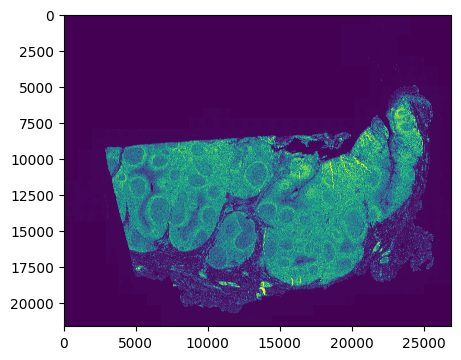

In [4]:
img1 = read_image(f"{in_dir}/Slide 1_20 min HIER 1h RT stain_Scan1.qptiff")
# use this to check which marker is which index in the qptiff
# indexing in python starts at 0 not at 1 like in R, so [0, :, :] = C1 in the qptiff
plt.figure(figsize = (5, 5))
plt.imshow(img1[0, :, :])

Text(0.5, 1.0, 'membrane1')

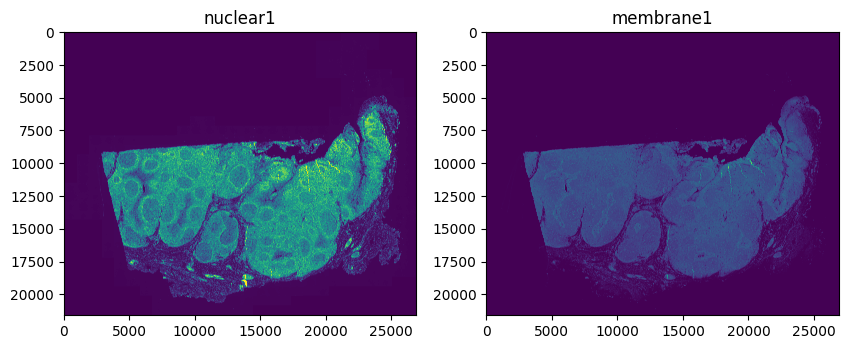

In [5]:
nuclear1, membrane1 = generate_nuclear_and_membrane(img1)
# show the final nuclear and membrane arrays as images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nuclear1)
ax[1].imshow(membrane1)

ax[0].set_title('nuclear1')
ax[1].set_title('membrane1')

In [7]:
# save nuclear and membrane tiffs for future reference 
# (can also check that nuclear is actually nuclear by opening the image, hard to tell in a python notebook)
imsave(f"{out_dir}/MESMER_outputs/nuclear1.tiff", nuclear1, check_contrast = False)
imsave(f"{out_dir}/MESMER_outputs/membrane1.tiff", membrane1, check_contrast = False)

In [6]:
stacked_img1 = stack_nuclear_and_membrane(nuclear=nuclear1, membrane=membrane1)

In [8]:
y_min1 = 9500
y_max1 = 15000
x_min1 = 5000
x_max1 = 12000

Text(0.5, 1.0, 'cropped1')

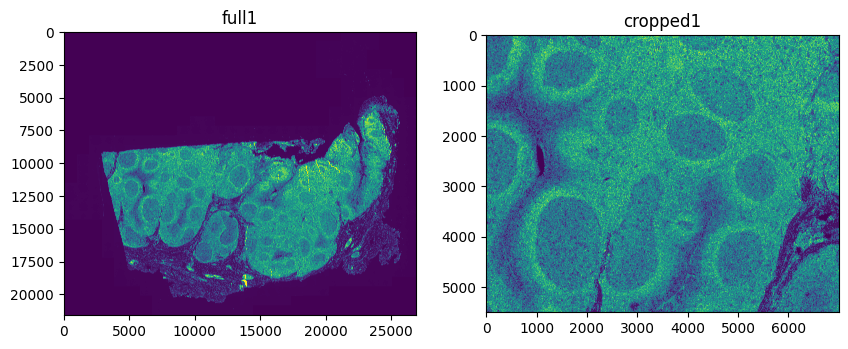

In [11]:
# crop out area of interest
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(stacked_img1[0, :, :, 0])
ax[1].imshow(stacked_img1[0, y_min1:y_max1, x_min1:x_max1, 0])

ax[0].set_title('full1')
ax[1].set_title('cropped1')

In [9]:
stacked_img1.shape

(1, 21600, 26880, 2)

In [13]:
cropped_stack1 = stacked_img1[:, y_min1:y_max1, x_min1:x_max1, :]
cropped_stack1.shape

(1, 5500, 7000, 2)

In [10]:
cropped_stack1 = crop_out(stacked_img1, xmin=x_min1, xmax=x_max1, ymin=y_min1, ymax=y_max1)
cropped_stack1.shape

9500
15000
5000
12000


(1, 5500, 7000, 2)

In [18]:
y_max1

15000

In [11]:
maxima_threshold = 0.075
interior_threshold = 0.2

In [12]:
# maxima_threshold controls what is considered a unique cell (lower values = more separate cells, higher values = fewer cells)
# interior_threshold determines what is considered background/not part of a cell (lower value = larger cells)
predictions1 = run_segmentation(img=cropped_stack1, maxima_threshold=maxima_threshold, interior_threshold=interior_threshold)

INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting /users/PCON0100/feng1426/.deepcell/models/MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted /users/PCON0100/feng1426/.deepcell/models/MultiplexSegmentation-9.tar.gz into /users/PCON0100/feng1426/.deepcell/models
2024-08-30 21:20:05.115146: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 21:20:05.260639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, nam

2024-08-30 21:20:24.015089: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
/users/PCON0100/feng1426/.local/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


In [13]:
MESMER_output_dir = f'{out_dir}/MESMER_outputs/{maxima_threshold}maxima_1_{interior_threshold}interior_1'

In [14]:
rgb_image = create_rgb_image(cropped_stack1, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions1)

# save MESMER outputs
if not os.path.exists(MESMER_output_dir):
    os.makedirs(MESMER_output_dir)

skimage.io.imsave(MESMER_output_dir + "/seg_outline1.tiff", img_as_ubyte(overlay[0, ..., 0]), check_contrast = False) # segmentation outline
skimage.io.imsave(MESMER_output_dir + "/seg_overlay1.tiff", img_as_ubyte(overlay[0, ...]), check_contrast = False) # segmentation overlay (nuc + membrane + outline)
skimage.io.imsave(MESMER_output_dir + "/MESMER_mask1.tiff", predictions1[0, ..., 0], check_contrast = False) # MESMER mask

### Extract SC features

In [15]:
data_full1, dataScale_full1 = extract_sc_features(
    img=img1, 
    mesmer_result_fn=MESMER_output_dir+"/MESMER_mask1.tiff",
    xmin=x_min1, ymin=y_min1, xmax=x_max1, ymax=y_max1,
)

100%|██████████| 176468/176468 [01:05<00:00, 2685.49it/s]


In [16]:
data_full1.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.866667,419.644444,45.0,5575.0,31.0,222.0,8.0,1924.0,3.0,...,132.0,397.0,222.0,18.0,18.0,314.0,519.0,2626.0,14.0,3821.0
1,2.0,1.457143,495.028571,35.0,4705.0,155.0,118.0,3.0,1973.0,7.0,...,104.0,288.0,181.0,18.0,14.0,227.0,845.0,1889.0,3.0,2981.0
2,3.0,1.193548,638.193548,31.0,6100.0,50.0,120.0,10.0,1449.0,174.0,...,95.0,238.0,148.0,43.0,20.0,244.0,389.0,1883.0,7.0,2635.0
3,4.0,1.400000,1278.533333,30.0,2249.0,17.0,69.0,0.0,1602.0,3.0,...,54.0,337.0,168.0,340.0,13.0,182.0,585.0,1584.0,1.0,1606.0
4,5.0,1.312500,2471.687500,32.0,4318.0,456.0,108.0,9.0,3054.0,3.0,...,59.0,273.0,191.0,8.0,14.0,201.0,1307.0,1613.0,6.0,2134.0


In [17]:
dataScale_full1.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.866667,419.644444,45.0,123.888889,0.688889,4.933333,0.177778,42.755556,0.066667,...,2.933333,8.822222,4.933333,0.400000,0.400000,6.977778,11.533333,58.355556,0.311111,84.911111
1,2.0,1.457143,495.028571,35.0,134.428571,4.428571,3.371429,0.085714,56.371429,0.200000,...,2.971429,8.228571,5.171429,0.514286,0.400000,6.485714,24.142857,53.971429,0.085714,85.171429
2,3.0,1.193548,638.193548,31.0,196.774194,1.612903,3.870968,0.322581,46.741935,5.612903,...,3.064516,7.677419,4.774194,1.387097,0.645161,7.870968,12.548387,60.741935,0.225806,85.000000
3,4.0,1.400000,1278.533333,30.0,74.966667,0.566667,2.300000,0.000000,53.400000,0.100000,...,1.800000,11.233333,5.600000,11.333333,0.433333,6.066667,19.500000,52.800000,0.033333,53.533333
4,5.0,1.312500,2471.687500,32.0,134.937500,14.250000,3.375000,0.281250,95.437500,0.093750,...,1.843750,8.531250,5.968750,0.250000,0.437500,6.281250,40.843750,50.406250,0.187500,66.687500


In [18]:
data_full1.to_csv(os.path.join(out_dir, 'data_slide1.csv'), index = False)
dataScale_full1.to_csv(os.path.join(out_dir, 'dataScaleSize_slide1.csv'), index = False)

# slide 2

### Segmentation

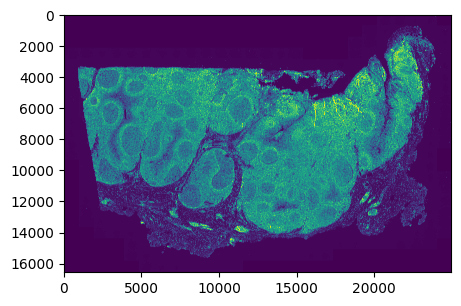

In [23]:
img2 = read_image(f"{in_dir}/Slide 2_20 min HIER on 4C stain_Scan1.qptiff")
# use this to check which marker is which index in the qptiff
# indexing in python starts at 0 not at 1 like in R, so [0, :, :] = C1 in the qptiff
plt.figure(figsize = (5, 5))
plt.imshow(img2[0, :, :])

Text(0.5, 1.0, 'membrane2')

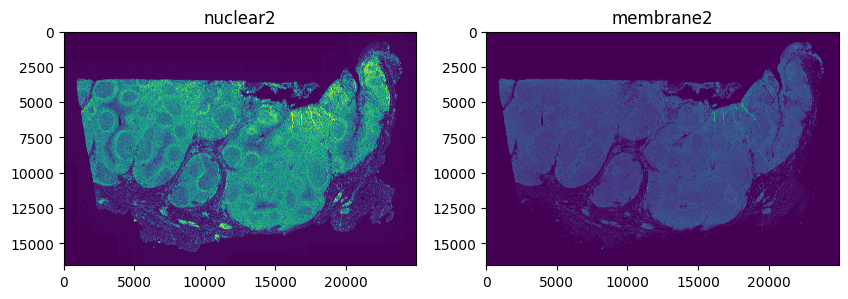

In [24]:
nuclear2, membrane2 = generate_nuclear_and_membrane(img2)
# show the final nuclear and membrane arrays as images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(nuclear2)
ax[1].imshow(membrane2)

ax[0].set_title('nuclear2')
ax[1].set_title('membrane2')

In [25]:
# save nuclear and membrane tiffs for future reference 
# (can also check that nuclear is actually nuclear by opening the image, hard to tell in a python notebook)
imsave(f"{out_dir}/MESMER_outputs/nuclear2.tiff", nuclear2, check_contrast = False)
imsave(f"{out_dir}/MESMER_outputs/membrane2.tiff", membrane2, check_contrast = False)

In [26]:
stacked_img2 = stack_nuclear_and_membrane(nuclear=nuclear2, membrane=membrane2)

In [27]:
y_min2 = 4000
y_max2 = 9500
x_min2 = 3000
x_max2 = 10000

Text(0.5, 1.0, 'cropped2')

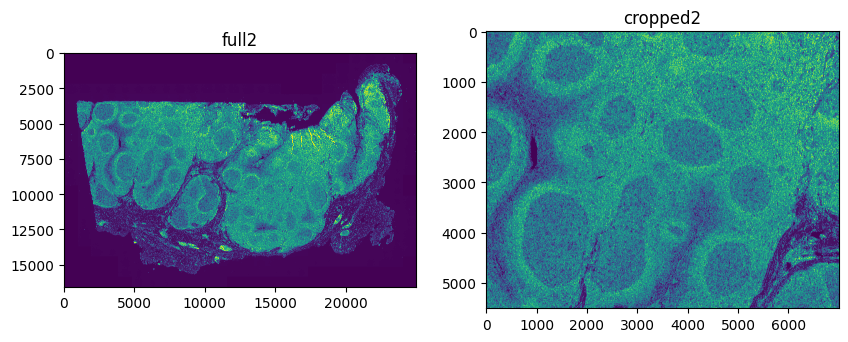

In [28]:
# crop out area of interest
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(stacked_img2[0, :, :, 0])
ax[1].imshow(stacked_img2[0, y_min2:y_max2, x_min2:x_max2, 0])

ax[0].set_title('full2')
ax[1].set_title('cropped2')

In [29]:
cropped_stack2 = crop_out(stacked_img2, xmin=x_min2, xmax=x_max2, ymin=y_min2, ymax=y_max2)
cropped_stack2.shape

4000
9500
3000
10000


(1, 5500, 7000, 2)

In [30]:
# maxima_threshold controls what is considered a unique cell (lower values = more separate cells, higher values = fewer cells)
# interior_threshold determines what is considered background/not part of a cell (lower value = larger cells)
predictions2 = run_segmentation(img=cropped_stack2, maxima_threshold=maxima_threshold, interior_threshold=interior_threshold)

INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting /users/PCON0100/feng1426/.deepcell/models/MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted /users/PCON0100/feng1426/.deepcell/models/MultiplexSegmentation-9.tar.gz into /users/PCON0100/feng1426/.deepcell/models


/users/PCON0100/feng1426/.local/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


In [31]:
rgb_image = create_rgb_image(cropped_stack2, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions2)

# save MESMER outputs
if not os.path.exists(MESMER_output_dir):
    os.makedirs(MESMER_output_dir)

skimage.io.imsave(MESMER_output_dir + "/seg_outline2.tiff", img_as_ubyte(overlay[0, ..., 0]), check_contrast = False) # segmentation outline
skimage.io.imsave(MESMER_output_dir + "/seg_overlay2.tiff", img_as_ubyte(overlay[0, ...]), check_contrast = False) # segmentation overlay (nuc + membrane + outline)
skimage.io.imsave(MESMER_output_dir + "/MESMER_mask2.tiff", predictions2[0, ..., 0], check_contrast = False) # MESMER mask

### Extract SC fetures

In [33]:
data_full2, dataScale_full2 = extract_sc_features(
    img=img2, 
    mesmer_result_fn=MESMER_output_dir+"/MESMER_mask2.tiff",
    xmin=x_min2, ymin=y_min2, xmax=x_max2, ymax=y_max2,
)

100%|██████████| 173118/173118 [01:06<00:00, 2619.32it/s]


In [34]:
data_full2.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.744681,2594.085106,47.0,8101.0,722.0,299.0,10.0,3150.0,19.0,...,125.0,1259.0,62.0,21.0,87.0,763.0,1512.0,673.0,4.0,2985.0
1,2.0,0.750000,3122.350000,20.0,3044.0,56.0,134.0,4.0,579.0,3.0,...,38.0,451.0,8.0,4.0,19.0,329.0,582.0,855.0,1.0,1129.0
2,3.0,1.314286,3557.000000,35.0,5679.0,350.0,192.0,10.0,1036.0,214.0,...,117.0,1779.0,40.0,16.0,49.0,508.0,883.0,537.0,5.0,2164.0
3,4.0,0.772727,3716.000000,22.0,3671.0,223.0,114.0,2.0,745.0,54.0,...,58.0,520.0,33.0,12.0,35.0,331.0,597.0,310.0,1.0,1396.0
4,5.0,2.133333,26.733333,60.0,4953.0,51.0,163.0,3.0,658.0,21.0,...,126.0,722.0,14.0,28.0,58.0,525.0,959.0,2090.0,5.0,3424.0


In [35]:
dataScale_full2.head()

,cellLabel,Y_cent,X_cent,cellSize,DAPI,CD3,aSMA,CD15,CD4,CD8,...,CD163,H3K27ac,Granzyme.B,CD31,CD206,CD138,NaK.ATPase,CD45RA,CD45,Cytokeratin
0,1.0,1.744681,2594.085106,47.0,172.361702,15.361702,6.361702,0.212766,67.021277,0.404255,...,2.659574,26.787234,1.319149,0.446809,1.851064,16.234043,32.170213,14.319149,0.085106,63.510638
1,2.0,0.750000,3122.350000,20.0,152.200000,2.800000,6.700000,0.200000,28.950000,0.150000,...,1.900000,22.550000,0.400000,0.200000,0.950000,16.450000,29.100000,42.750000,0.050000,56.450000
2,3.0,1.314286,3557.000000,35.0,162.257143,10.000000,5.485714,0.285714,29.600000,6.114286,...,3.342857,50.828571,1.142857,0.457143,1.400000,14.514286,25.228571,15.342857,0.142857,61.828571
3,4.0,0.772727,3716.000000,22.0,166.863636,10.136364,5.181818,0.090909,33.863636,2.454545,...,2.636364,23.636364,1.500000,0.545455,1.590909,15.045455,27.136364,14.090909,0.045455,63.454545
4,5.0,2.133333,26.733333,60.0,82.550000,0.850000,2.716667,0.050000,10.966667,0.350000,...,2.100000,12.033333,0.233333,0.466667,0.966667,8.750000,15.983333,34.833333,0.083333,57.066667


In [36]:
data_full2.to_csv(os.path.join(out_dir, 'data_slide2.csv'), index = False)
dataScale_full2.to_csv(os.path.join(out_dir, 'dataScaleSize_slide2.csv'), index = False)